# Transfer Learning

![tranfer_inner_chi](assets/transfer/transfer_inner_chi.jpg)

(image: kuailexiaorongrong.blog.163.com, via https://sg.news.yahoo.com/6-kungfu-moves-movies-wished-194241611.html)

# Topics

- Introduction & motivation
- Adapting Neural Networks
- Process

# Transfer Learning

Transfering the knowledge of one model to perform a new task.

"Domain Adaptation"

## Motivation

- Lots of data, time, resources needed to train and tune a neural network from scratch
  - An ImageNet deep neural net can take weeks to train and fine-tune from scratch.
  - Unless you have 256 GPUs, possible to achieve in [1 hour](https://research.fb.com/publications/accurate-large-minibatch-sgd-training-imagenet-in-1-hour/)
- Cheaper, faster way of adapting a neural network by exploiting their generalization properties

## Traditional vs. Transfer Learning

![tradition_v_transfer](assets/transfer/traditional_v_transfer.png)

(image: [Survey on Transfer Learning](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.147.9185&rep=rep1&type=pdf))

## Transfer Learning Types


|Type|Description|Examples|
|--|--|--|
|Inductive|Adapt existing **supervised** training model on new **labeled** dataset|Classification, Regression|
|Transductive|Adapt existing **supervised** training model on new **unlabeled** dataset|Classification, Regression|
|Unsupervised|Adapt existing **unsupervised** training model on new **unlabeled** dataset|Clustering, Dimensionality Reduction|

## Transfer Learning Applications

- Image classification (most common): learn new image classes
- Text sentiment classification
- Text translation to new languages
- Speaker adaptation in speech recognition
- Question answering

## Transfer Learning Services

Transfer learning is used in many "train your own AI model" services:
  - just upload 5-10 images to train a new model! in minutes!

![custom vision](assets/transfer/custom-vision.png)

(image: https://azure.microsoft.com/en-us/services/cognitive-services/custom-vision-service/)

# Transfer Learning in Neural Networks

## Neural Network Layers: General to Specific 

- Bottom/first/earlier layers: general learners
 - Low-level notions of edges, visual shapes

- Top/last/later layers: specific learners
  - High-level features such as eyes, feathers
  
Note: the top/bottom notation is confusing, I'd avoid it

## Example: VGG 16 Filters

![vgg filters](assets/transfer/vgg16_filters_overview.jpg)

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

![overview](assets/transfer/Transfer+Learning+Overview.jpg)

(image: [Aghamirzaie & Salomon](http://slideplayer.com/slide/8370683/))

# Process

1. Start with pre-trained network

2. Partition network into:
 - Featurizers: identify which layers to keep
 - Classifiers: identify which layers to replace

3. Re-train classifier layers with new data

4. Unfreeze weights and fine-tune whole network with smaller learning rate

## Freezing and Fine-tuning

![vgg 16 modified](assets/transfer/vgg16_modified.png)

(image: http://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

## Which layers to re-train?

- Depends on the domain
- Start by re-training the last layers (last full-connected and last convolutional)
  - work backwards if performance is not satisfactory

## Example

![transfer performance](assets/transfer/transfer_performance.png)

(image: http://arxiv.org/abs/1411.1792)

## When and how to fine-tune?

Suppose we have model A, trained on dataset A
Q: How do we apply transfer learning to dataset B to create model B?

|Dataset size|Dataset similarity|Recommendation|
|--|--|--|
|Large|Very different|Train model B from scratch, initialize weights from model A|
|Large|Similar|OK to fine-tune (less likely to overfit)|
|Small|Very different|Train classifier using the earlier layers (later layers won't help much)|
|Small|Similar|Don't fine-tune (overfitting). Train a linear classifier|

https://cs231n.github.io/transfer-learning/

## Learning Rates

- Training linear classifier: typical learning rate

- Fine-tuning: use smaller learning rate to avoid distorting the existing weights
  - Assumes weights are close to "good"

# Workshop: Learning New Image Classes

In this workshop, we will:
- Create a dataset of new classes not found in ImageNet
- Perform inductive transfer learning on a pre-trained ImageNet neural network
- Evaluate the results

Credits: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Gather your dataset

We will create a new dataset to perform a new 2-class classification task.

1. Pick a category that is NOT found in ImageNet
  - For reference, the 1000 imagenet classes are here: http://image-net.org/challenges/LSVRC/2014/browse-synsets

2. Download the images from the web. Organize them in a directory structure like this:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```            

Guidelines
  - Provide at least 5 training images per class. The more the better.
  - Use any standard image format, such as jpg and png 
  - Use different images for the training and validation sets, to avoid overfitting
  - A sample dataset is available in the data folder

### Set dataset path and labels
Update `dataset_path` with the path to your dataset
- You can use an absolute path (e.g. 'D:/tmp/data') or a relative path

Update `labels` with the labels for your dataset

In [121]:
# Update to set the path of your dataset
# You can use an absolute path (e.g. 'D:/tmp/data') or a relative path
dataset_path='./data'

# Update to set the labels for your dataset
labels=['lrt', 'mrt']

In [102]:
def count_image_files(folder_name, extensions=['png', 'jpg']):
    """Counts 1-level nested image files in a folder
    Arg:
        folder_name: name of folder to search
        extensions: array of image file extensions
    Returns:
        number of image files
    """
    from functools import reduce
    import glob
    return reduce((lambda x, y: x + y),
        [len(glob.glob('%s/**/*.%s' % (folder_name, ext), recursive=True))
            for ext in extensions])

In [103]:
import os

train_folder = os.path.join(dataset_path, 'train')
n_train_set = count_image_files(train_folder)

print('Training set size:', n_train_set)

val_folder = os.path.join(dataset_path, 'validation')
n_val_set = count_image_files(val_folder)
print('Validation set size:', n_val_set)

Training set size: 26
Validation set size: 10


### Perform Data Augmentation

- Data Augmentation is a technique to improve the performance of classification models
  - This is especially helpful for small training datasets
  - http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf

- We will use `keras.preprocessing.image.ImageDataGenerator` to randomly rotate and horizontal flip our training data.
  - This is documented in https://keras.io/preprocessing/image/

Found 26 images belonging to 2 classes.


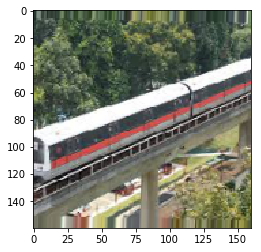

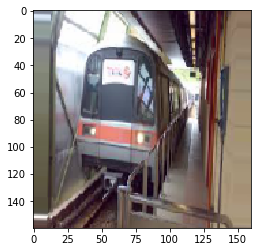

In [47]:
# https://keras.io/preprocessing/image/#imagedatagenerator-class
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# 160x160 matches one of the sizes supported by MobileNet
# (the neural network we'll transfer learn from)
img_height = img_width = 160
channels = 3

datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=5,
                            zoom_range=.2,
                            horizontal_flip=True)

# generate image data from the training set
generator = datagen.flow_from_directory(train_folder,
                                        color_mode='rgb',
                                        target_size=(img_height, img_width),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=True)

# display some images
x, y = next(generator)
plt.imshow(x[0])
plt.show()

x, y = next(generator)
plt.imshow(x[0])
plt.show()

## Baseline Model - 4-layer CNN from scratch

As a baseline, let's train a simple Convolutional Neural Network to do binary classification.

This will be trained from scratch and compared against the transfer learning model(s).

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation,\
    BatchNormalization, Flatten, Dense

model = Sequential()

# Convolutional Block 1
# depth 8, kernel 3, stride 1, with padding
# input shape: 160, 160, 3 
# output shape (of the block): 53, 53, 8
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same',
                 activation='relu',
                 input_shape=(img_width, img_height, channels)))
# Note: input_shape is inferred for subsequent layers
model.add(MaxPool2D(pool_size=(3,3)))

# Convolutional Block 2
# depth 16, kernel 3, stride 1, with padding
# input shape: 53, 53, 8 
# output shape (of the block): 26, 26, 16
# Note: Batch norm is inserted before activation for 2nd conv block onwards
#       Batch Norm removes noise in the covariates (means, variances)
#       when we stack convolutional blocks
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional Block 3
# depth 32, kernel 3, stride 1, with padding
# input shape: 26, 26, 16
# output shape (of the block): 13, 13, 32
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional Block 4
# depth 32, kernel 3, stride 1, with padding
# input shape: 13, 13, 32
# output shape (of the block): 6, 6, 32
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Binary classifier
# input shape: 6, 6, 32
# output shape: 1
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 160, 160, 8)       224       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 53, 53, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 53, 53, 16)        64        
_________________________________________________________________
activation_4 (Activation)    (None, 53, 53, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        4640      
__________

### TensorBoard - Monitoring Training Progress

This is the first time we're training neural networks in keras.
- We'll be using the default backend of keras, which is Tensorflow.
- Therefore, we can use [Tensorboard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) to view training progress and metrics.

TensorBoard is already included in Tensorflow, so there is no separate installation required.

### Launching TensorBoard

#### Windows
Launch a new Anaconda prompt:

```
activate mldds03
cd \path\to\mldds-courseware\03_TextImage
mkdir logs
tensorboard --logdir=./logs --host=0.0.0.0 --port=8008
```

#### MacOS / Ubuntu
Launch a new terminal:

```
source activate mldds03
cd /path/to/mldds-courseware/03_TextImage
mkdir logs
tensorboard --logdir=./logs --host=0.0.0.0 --port=8008
```

### Viewing TensorBoard

Once you see TensorBoard launched, you can navigate to http://localhost:8008

In [49]:
from keras.callbacks import TensorBoard
import time

batch_size = 1 # feel free to increase this if you have more images

train_generator = datagen.flow_from_directory(train_folder,
                                              color_mode='rgb',
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True)

# make a unique log index so that it's easier to filter
# by training sessions
log_index = int(time.time())

# we set histogram_freq=0 because we are using a generator
tensorboard = TensorBoard(log_dir='./logs/baseline_cnn/%s' % log_index,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator,
                    n_train_set//batch_size,
                    epochs=4,
                    callbacks=[tensorboard])

Found 26 images belonging to 2 classes.
Epoch 1/4
29/29 [==============================] - 2s 72ms/step - loss: 1.1868 - acc: 0.2759
Epoch 2/4
29/29 [==============================] - 1s 49ms/step - loss: 0.5746 - acc: 0.7241
Epoch 3/4
29/29 [==============================] - 1s 45ms/step - loss: 0.5594 - acc: 0.7241
Epoch 4/4
29/29 [==============================] - 1s 51ms/step - loss: 0.3403 - acc: 0.8966


You can view training progress from Tensorboard by going to http://localhost:8008

![tensorboard](assets/transfer/tensorboard-demo.png)

## Exercise - Classification Model Validation
 
1. Create a test_generator using datagen.flow_from_directory, but point it to the validation folder and set batch_size to all available test samples
```
test_generator = datagen.flow_from_directory(val_folder,
                                                color_mode='rgb',
                                                target_size=(img_height, img_width),
                                                batch_size=n_val_set,
                                                class_mode='binary',
                                                shuffle=False)
test_x, test_y = next(test_generator)
```

2. Run predictions using the CNN we just trained
```
pred_y = model.predict(test_x)
```
3. The predictions from the CNN are continuous values, so we need to convert them to binary
```
pred_y = np.where(pred_y > 0.5, 1, 0)
```
4. Use sklearn.metrics to evaluate the classification model (using confusion_matrix, classification_report).


### Setup

You may need to install sklearn into your conda environment.

```
conda install scikit-learn
```

In [51]:
# Your code here
from sklearn.metrics import confusion_matrix, classification_report

test_generator = datagen.flow_from_directory(val_folder,
                                             color_mode='rgb',
                                             target_size=(img_height, img_width),
                                             batch_size=n_val_set,
                                             class_mode='binary',
                                             shuffle=False)

test_x, test_y = next(test_generator)

pred_y = model.predict(test_x)
pred_y = np.where(pred_y > 0.5, 1, 0)

print(classification_report(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

Found 10 images belonging to 2 classes.
             precision    recall  f1-score   support

        0.0       0.60      0.60      0.60         5
        1.0       0.60      0.60      0.60         5

avg / total       0.60      0.60      0.60        10

[[3 2]
 [2 3]]


## Transfer Learning with ImageNet MobileNet

Now that we have our baseline CNN, let's try transfer learning. 

2 Steps:
1. Freeze and retrain a classifier on top of MobileNet
2. Un-freeze and fine-tune the model we got from step 2

### Load the featurizer portion of MobileNet

In [135]:
from keras.applications import MobileNet

datagen = ImageDataGenerator(rescale=1./255)

# Exclude the Dense layer from the network by setting include_top=False
# We are going to re-train a classifier with the remaining layers
model_mn = MobileNet(include_top=False,
                     weights='imagenet',
                     input_shape=(img_width, img_height, channels))
model_mn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 162, 162, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 82, 82, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
__________

### Freeze the featurizer weights

If the weights and labels were not previously saved:
  1. Run the training set through the MobileNet featurizer
  2. Save the output of the featurizer and corresponding training set labels

Else load the weights and labels from files.

Since this is supervised learning, we need both the weights and labels to train the classifier.

In [136]:
# For large neural networks such as VGG, it is a good idea to save the
# weights to a file that we load during transfer learning training.

# https://wiki.python.org/moin/UsingPickle
import pickle
weights_file = 'mobilenet_features_train.npy'
labels_file = 'mobilenet_labels_train.npy'

batch_size = 1 # feel free to increase this if you have more images

if os.path.isfile(weights_file) and os.path.isfile(labels_file):
    print('Loading weights from %s:' % weights_file)
    with open(weights_file, 'rb') as f:
        features_train = pickle.load(f)
        
    print('Loading labels from %s:' % labels_file)
    with open(labels_file, 'rb') as f:
        labels_train = pickle.load(f)
        
else:
    print('Saving weights to %s:' % weights_file)
    train_generator = datagen.flow_from_directory(train_folder,
                                                  color_mode='rgb',
                                                  target_size=(img_height, img_width),
                                                  batch_size=n_train_set,
                                                  class_mode='binary')

    print('Saving labels to %s:' % labels_file)
    
    # capture the featurizer weights and labels
    train_x, labels_train = next(train_generator)

    features_train = model_mn.predict(train_x)    

    # save to file
    pickle.dump(features_train, open(weights_file, 'wb'))
    pickle.dump(labels_train, open(labels_file, 'wb'))
    
print('features_train.shape:', features_train.shape)
print('labels_train:', labels_train)

Saving weights to mobilenet_features_train.npy:
Found 26 images belonging to 2 classes.
Saving labels to mobilenet_labels_train.npy:
features_train.shape: (26, 5, 5, 1024)
labels_train: [0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0.]


### Train a new classifier with the frozen weights

Now that we have the featurizer weights, we can:

1. Create a general classifier.
2. Train the classifier with the weights (X) and labels (y).

#### Create a general classifier

Note that this classifier does not have to be related to the architecture of the original network.

It simply treats the inputs as opaque features.

In [137]:
from keras.layers import Flatten, Dense, Dropout

model_trf = Sequential()
model_trf.add(Flatten(input_shape=features_train.shape[1:])) # flatten (5, 5, 1024) to vector
model_trf.add(Dense(512, activation='relu'))
model_trf.add(Dropout(0.5))
model_trf.add(Dense(1, activation='sigmoid'))

model_trf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 25600)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               13107712  
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 513       
Total params: 13,108,225
Trainable params: 13,108,225
Non-trainable params: 0
_________________________________________________________________


## Exercise: Train the classifier

1. Setup a tensorboard callback
```
tensorboard = TensorBoard(log_dir='./logs/mobilenet_trf/%s' % log_index,
                              histogram_freq=0,
                              write_graph=True,
                              write_images=False)
```

2. Run compile the model, then fit with the features and labels

```
model_trf.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

model_trf.fit(x=features_train,
                  y=labels_train,
                  batch_size=batch_size,
                  epochs=15, # adjust this number based on your data
                  callbacks=[tensorboard])
```

In [ ]:
# Your code here

tensorboard = TensorBoard(log_dir='./logs/mobilenet_trf/%s' % log_index,
                           histogram_freq=0,
                           write_graph=True,
                           write_images=False)

model_trf.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

model_trf.fit(x=features_train,
              y=labels_train,
              batch_size=batch_size,
              epochs=15,
              callbacks=[tensorboard])

### Evaluate the model

Evaluating the transfer learnt model is not as straightforward as giving it the test inputs.

We'll need to:
1. Get the validation set features (and labels) from the MobileNet featurizer
2. Pass the features into the classifier to get the predictions.

In [133]:
test_generator = datagen.flow_from_directory(val_folder,
                                             color_mode='rgb',
                                             target_size=(img_height, img_width),
                                             batch_size=n_val_set,
                                             class_mode='binary',
                                             shuffle=False)

# Get the validation set features (and labels) from the MobileNet featurizer
test_x, test_y = next(test_generator)
test_features = model_mn.predict(test_x)

# Pass the features into the classifier to get the predictions.
pred_y = model_trf.predict(test_features)

# Evaluate metrics
print(classification_report(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

Found 10 images belonging to 2 classes.
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         5
        1.0       0.50      1.00      0.67         5

avg / total       0.25      0.50      0.33        10

[[0 5]
 [0 5]]


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Reading List

|Material|Read it for|URL|
|--|--|--|
|A Survey on Transfer Learning (IEEE)|Overview of transfer learning|http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.147.9185&rep=rep1&type=pdf|
|Transductive Learning: Motivation, Model, Algorithms|Explanation of Induction vs. Transduction Transfer Learning|http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/pdfs/pdf2527.pdf|
|Supervised and Unsupervised Transfer Learning for Question Answering (Paper)|More unique application of transfer learning|https://arxiv.org/abs/1711.05345|